In [633]:
######################
# IMPORT DEPENDECIES #
######################

import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [634]:
################
# LOAD DATASET #
################

data = pd.read_csv(r"master.csv ")

data

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


In [635]:
##################
# DATA WRANGLING #
##################

# SUBSTITUTE AGE AND SEX RELATED NON-NUMERICAL DATA
# WITH NUMERICAL DATA BASED ON CLASSIFICATIONS.
# THIS MUST BE DONE TO HAVE MULTIPLE NUMERICAL
# VALUES TO CALCULATE THE 'θi Xi' VALUES



# GET ALL VALUES FROM THE DATASET REGARDING AGE
age_data = pd.DataFrame(data["age"])

# REMOVE DUPLICATE VALUES
age_data.drop_duplicates(inplace=True)

# CREATE NUMERICAL CLASSFICATIONS 
age_classification = {}

# CONVERT THE DATAFRAME CONTAINING THE AGE DATA INTO AN ARRAY
age_ranges_arr = np.asarray(age_data)

# ITERATE OVER THE ARRAY CONTAINING THE AGE DATA
for i in range(len(age_ranges_arr)):

    # CONVERT THE AGE RANGE VALUE INTO A NUMERICAL VALUE BY CHANGING 
    # ITS VALUE INTO THE FIRST 2 CHARACTERS WITHIN THE RANGE
    # ( e.g. 15-24 years --> 15 )
    age_classification[age_ranges_arr[i][0]] = age_ranges_arr[i][0][0:2]

    # REMOVE POSSIBLE DASHES FROM THE AGE RANGES CONVERTED TO NUMERICAL VALUES
    # ( e.g. 5-14 --> 5- --> 5 )
    age_classification[age_ranges_arr[i][0]] = age_classification[age_ranges_arr[i][0]].replace("-", '')




# GET ALL VALUES FROM THE DATASET REGARDING SEX
sex_data = pd.DataFrame(data["sex"])

# REMOVE DUPLICATE VALUES
sex_data.drop_duplicates(inplace=True)

# CREATE NUMERICAL CLASSFICATIONS 
sex_classification = {}

# CONVERT THE DATAFRAME CONTAINING THE SEX DATA INTO AN ARRAY
sex_arr = np.asarray(sex_data)

# CONVERT THE MALE SEX CLASSIFICATION AS THE NUMERICAL VALUE OF 1
sex_classification["male"] = 1

# CONVERT THE FEMALE SEX CLASSIFICATION AS THE NUMERICAL VALUE OF 2
sex_classification["female"] = 2

# ADD THE CLASSIFICATIONS RELATED TO SEX AND AGE TO THE DATASET IN ITS OWN RESPECTIV ROW
for i in range(len(data)):
   data.at[i, "num_age"] = age_classification[data.loc[i]["age"]]
   data.at[i, "num_sex"] = sex_classification[data.loc[i]["sex"]]




# REMOVE THE REDUNTANT COLUMNS
for c in data.columns:
    if (c != "country") & (c != "suicides/100k pop") & (c != "num_age") & (c != "num_sex") & (c != "year"):
        data.drop(str(c), axis=1, inplace=True)


# NORMALISE THE DATA
data_copy = data.drop(columns=["num_sex", "num_age", "country", "year"], axis=1)
x = data_copy.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_copy = pd.DataFrame(x_scaled)
data["suicides/100k pop"] = data_copy[0]

# DROP ROWS WITH N/A VALUES
data.dropna()

data

,country,year,suicides/100k pop,num_age,num_sex
0,Albania,1987,0.029826,15,1.0
1,Albania,1987,0.023070,35,1.0
2,Albania,1987,0.021470,15,2.0
3,Albania,1987,0.020403,75,1.0
4,Albania,1987,0.014580,25,1.0
...,...,...,...,...,...
27815,Uzbekistan,2014,0.013157,35,2.0
27816,Uzbekistan,2014,0.011468,75,2.0
27817,Uzbekistan,2014,0.009646,5,1.0
27818,Uzbekistan,2014,0.007423,5,2.0


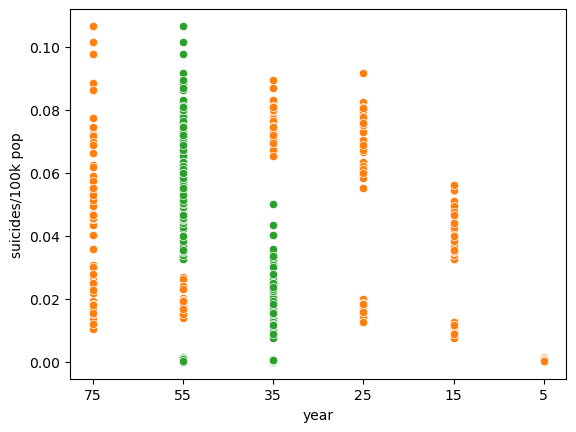

In [636]:
######################
# DATA VISUALISATION #
######################

alb = data[(data["country"] == "United Kingdom")]
alb_columns = ["year", "num_age", "num_sex"]

for col in alb_columns:
     sb.scatterplot(data=alb, x=col, y= "suicides/100k pop")

In [637]:
regr = linear_model.LinearRegression()

# GET ALL VALUES FROM THE DATASET REGARDING COUNTRIES
countries = pd.DataFrame(data["country"])

# REMOVE DUPLICATE VALUES
countries.drop_duplicates(inplace=True)




# DICTIRONARY AND ARRAYS USED TO STORE THE
# VALUES 'country', 'θ0', 'θ1 X1',
# 'θ2 X2', AND 'r1' GENERATED BY 
# THE LINEAR REGRESSION 
res = {}
country_arr = []
theta_0_arr = []
theta_1_arr = []
theta_2_arr = []
theta_3_arr = []
r2_arr = []


# CREATE A LINEAR REGRESSION MODEL FOR EACH COUNTRY.
# IN ORDER TO PREDICT THE SUICIDE RATE OF AN 
# INDIVIDUAL BASED ON HIS/HERS AGE AND GENDER
# THE CLASSIFICATION MUST BE DONE BY COUNTRY.
# THIS IS DUE TO THE FACT THAT EACH COUNTRY
# HAS ITS OWN SOCIO-ECONOMIC FACTORS AND
# THIS CLASSIFICATION WILL MAXIMISE THE
# ACCURACY OF THE MODELS

# ITERATE THROUGH EACH COUNTRY
for country in countries["country"]:

    # APPEND THE CURRENT COUNTRY TO THE COUNTRY ARRAY
    country_arr.append(country)

    # CONTRUCT A DATASET FROM DATA ASSOCIATED WITH THE CURRENT COUNTRY
    curr_country = data[(data["country"] == country)]

    # SPLIT 80% THE DATA IN THE DATASET ABOVE FOR TRAINING AND 20% OF THE DATA FOR TESTING 
    mask = np.random.rand(len(curr_country[curr_country.columns[1::]]), 0) < 0.8
    train = curr_country[mask]
    test = curr_country[~mask]


    # SELECT THE 'num_age' AND 'num_sex' VALUES AS THE 'X1' AND 'X2' VALUES
    x_train = np.asarray(train[["year", "num_age", "num_sex"]])


    # SELECT THE 'suicides/100k pop' VALUE AS THE 'Y' VALUES
    y_train = np.asarray(train[curr_country.columns[2]])


    # FIT THE X1, X2, AND Y VALUES IN THE LINEAR REGRESSION MODEL 
    # TO GET THE 'θ0', 'θ1 X1', AND 'θ2 X2' VALUES
    values = regr.fit(X=x_train, y=y_train)


    # APPEND THE 'θ0', 'θ1 X1', AND 'θ2 X2' VALUES TO THE
    # θ0 ARRAY AND θi ARRAY RESPECTIVELY
    theta_0_arr.append(values.intercept_)
    theta_1_arr.append(values.coef_[0])
    theta_2_arr.append(values.coef_[1])
    theta_3_arr.append(values.coef_[2])
    


    # SELECT THE 'num_age' AND 'num_sex' VALUES AS THE 'X1' AND 'X2' VALUES FOR TESTING
    x_test = np.asarray(test[["year", "num_age", "num_sex"]])

    # SELECT THE 'suicides/100k pop' VALUE AS THE 'Y' VALUES FOR TESTING
    y_test = np.asarray(test[curr_country.columns[2]])

    # PREDICT THE POSSIBLE VALUES OF Y BASED ON THE PROVIDED TESTING X VALUES
    y_predict = regr.predict(X=x_test)

    # EVALUATE THE ACCURACY USING THE 'r2' ALGORITHM
    r2 = r2_score(y_test, y_predict)

    # APPEND THE 'r2' RESULT TO THE R2 ARRAY
    r2_arr.append(r2)


# ASSOCIATE THE ARRAYS WITH THEIR SPECIFIC VALUES WITH SPECIFIC PROPRIETIES
# WITHIN A DICTIONARY
res["country"] = country_arr
res["theta_0"] = theta_0_arr
res["theta_1"] = theta_1_arr
res["theta_2"] = theta_2_arr
res["theta_3"] = theta_3_arr
res["r2"] = r2_arr

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by LinearRegression.

In [ ]:
###########################
# TRAINING DATA WRANGLING #
###########################


# CREATE A DATAFRAME FROM THE DICTIONARY GENERATED ABOVE
result = pd.DataFrame(res)

# COUNT THE TOTAL NUMBER OF ROWS WITHIN THE DATASET
print("Total count: " + str(len(result)))

# DROP ROWS THAT DO NOT MEET THE MINIMUM ACCURACY STANDARD OF A 0.5 'r2' VALUE
result.drop((result[(result["r2"] < 0.5)]).index, inplace=True)
result.drop((result[(result["theta_0"] == 0) & (result["theta_1"] == 0) & (result["theta_2"] == 0) & (result["theta_3"] == 0)]).index, inplace=True)
result.dropna(inplace=True)

# PRINT THE TOTAL NUMBER OF RESULTS AFTER THE DATA CLEANING
print("Total count after data cleaning: " + str(len(result)))

sex_class_data = pd.DataFrame(sex_classification, index=[0])
sex_class_data_csv = sex_class_data.to_csv(index=False)

age_class_data = pd.DataFrame(age_classification, index=[0])
age_class_data_csv = age_class_data.to_csv(index=False)

result_csv = result.to_csv(columns=result.columns[0::], index=False)

with open(file="machine_learning_model.csv", mode="w") as csv_writter:
    csv_writter.write(result_csv)
    csv_writter.close()

with open(file="sex_class_data.csv", mode="w") as csv_writter:
    csv_writter.write(sex_class_data_csv)
    csv_writter.close()

with open(file="age_class_data.csv", mode="w") as csv_writter:
    csv_writter.write(age_class_data_csv)
    csv_writter.close()

result

Total count: 101
Total count after data cleaning: 64


,country,theta_0,theta_1,theta_2,theta_3,r2
2,Argentina,0.797688,-0.000353,0.001227,-0.059327,0.634485
3,Armenia,0.221744,-0.000100,0.000464,-0.014838,0.619479
5,Australia,1.342965,-0.000603,0.000687,-0.068261,0.636258
6,Austria,5.561001,-0.002697,0.003374,-0.119456,0.743449
11,Belarus,2.304539,-0.000983,0.002592,-0.192752,0.691633
...,...,...,...,...,...,...
93,Turkey,-0.835603,0.000426,0.000174,-0.010826,0.690129
95,Ukraine,2.510461,-0.001126,0.002725,-0.157097,0.768639
97,United Kingdom,0.883958,-0.000406,0.000446,-0.036452,0.621805
98,United States,0.939187,-0.000399,0.001197,-0.081286,0.718015
